# Introduction to Numerical Methods for Stochastic Differential Equations

### $\textbf{Author:}$ Alexandre Thyrion

__Content inspired from__:  Higham, D. J. (2001). *An algorithmic introduction to numerical simulation of stochastic differential equations*. SIAM Review, 43(3), 525–546.  
Available at: [https://epubs.siam.org/doi/10.1137/S0036144500378302](https://epubs.siam.org/doi/10.1137/S0036144500378302)

# TP2 : Second Order Numerical Method for SDE

# Imports

**Run the cell below**

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Exercise 1 : Black-Scholes SDE to model stock prices evolution

![stockpriceplot](https://raw.githubusercontent.com/AlexandreThy/LINMA2720/refs/heads/main/img/stock.jpg)

Today, we will introduce an important application of Brownian Motion to model stock prices evolution, also called the **Black-Scholes Formula**, defined by the following SDE:
$$
dS(t) = \mu S(t)\,dt + \sigma S(t)\,dW(t), \quad S(0) = S_0
$$

where:  

- $ S(t)$ = stock price at time t
- $ \mu$= **drift rate** (expected return of the stock)  
- $ \sigma$ = **volatility** (standard deviation of returns, i.e. uncertainty)  
- $ W(t)$ = standard Wiener process (Brownian motion)  
- $ S_0 $= initial stock price  

## Intuition

- The **drift term** $ \mu S(t)\,dt $ captures the *deterministic growth* of the stock price over time.  
- The **diffusion term**  $ \sigma S(t)\,dW(t) $ captures the *random fluctuations* driven by market uncertainty.   


### **Q1** : Using the ITO-Formula, compute the analytical solution of the Black-Scholes SDE


**Solution** 

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t, \qquad S_0 > 0.
$$

Let $X_t = \ln S_t$.  
Itô's Formula gives:

$$
dX_t = \frac{1}{S_t} dS_t - \frac{1}{2}\frac{1}{S_t^2}(dS_t)^2.
$$

Substitute $dS_t$ and use $(dW_t)^2 = dt$:

$$
\begin{aligned}
dX_t
&= \frac{1}{S_t}(\mu S_t dt + \sigma S_t dW_t) - \frac{1}{2}\sigma^2 dt \\
&= \Bigl(\mu - \frac{1}{2}\sigma^2\Bigr) dt + \sigma dW_t.
\end{aligned}
$$

Integrate over $[0,t]$:

$$
X_t = X_0 + \Bigl(\mu - \frac{1}{2}\sigma^2\Bigr)t + \sigma W_t.
$$

Hence

$$
\ln S_t = \ln S_0 + \Bigl(\mu - \frac{1}{2}\sigma^2\Bigr)t + \sigma W_t.
$$

$$
\boxed{ \displaystyle
S_t = S_0 \exp\!\Bigl[\Bigl(\mu - \frac{1}{2}\sigma^2\Bigr)t + \sigma W_t\Bigr] }.
$$


### **Q2** : Simulate the Black-Scholes SDE using the Euler-Maruyama Method, and plot the solution for three different timesteps against the analytical solution

Text(0, 0.5, 'Asset Price $S_t$')

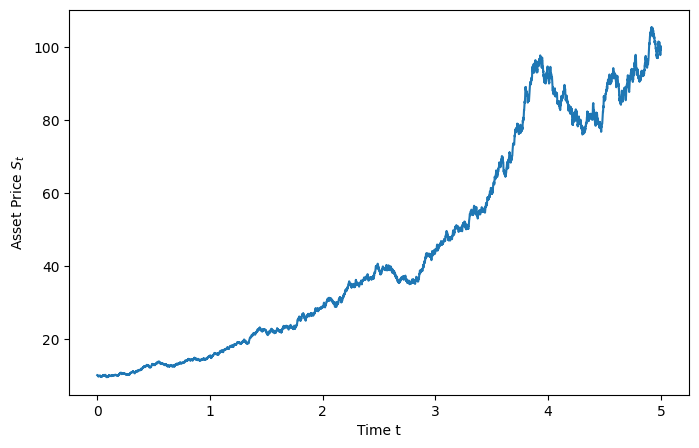

In [271]:
def euler_maruyama_blackscholes(mu, sigma, X0, T, N):

    dt = T / N
    t = np.linspace(0, T, N+1)
    X = np.zeros( N+1)
    X[ 0] = X0

    for i in range(N):
        dW = np.sqrt(dt) * np.random.randn()
        X[ i+1] = X[ i] + mu* X[i] * dt + sigma * X[ i] * dW
    return t, X
mu = 0.5
sigma = 0.2  
X0 = 10  
T = 5      
N = 5000     
t, S = euler_maruyama_blackscholes(mu, sigma, X0, T, N)

plt.figure(figsize=(8, 5))
plt.plot(t, S)
plt.xlabel("Time t")
plt.ylabel("Asset Price $S_t$")


### **Q3** : Find the probability that S(2t) > 2S(t) for some t > 0

## Solution

The inequality is equivalent to  

$$
\exp \big( 2\mu t - \tfrac{1}{2}\sigma^2 t + \sigma W(2t) \big) 
> 2 \exp \big( \mu t - \tfrac{1}{2}\sigma^2 t + \sigma W(t) \big).
$$  

After rearranging this becomes  

$$
\exp \big( \sigma [ W(2t) - W(t) ] \big) 
> \exp \big( \ln 2 - \mu t + \tfrac{1}{2}\sigma^2 t \big).
$$  

which is equivalent to  

$$
W(2t) - W(t) > \frac{1}{\sigma}\Big( \ln 2 - \mu t + \tfrac{1}{2}\sigma^2 t \Big).
$$  

Writing $W(2t) - W(t) = \sqrt{t}\,X$, where $X \sim N(0,1)$, we can see that the probability of the above event is  

$$
1 - N\!\left( \frac{1}{\sigma\sqrt{t}}\Big( \ln 2 - \mu t + \tfrac{1}{2}\sigma^2 t \Big) \right),
$$  

where $N$ is the standard normal cumulative distribution function.


# Exercise 2 : From Euler–Maruyama to Milstein’s Method

In the previous practice session we saw that the **Euler–Maruyama (EM)** scheme has **strong order of convergence**  
$$
\gamma = \tfrac{1}{2},
$$  
whereas the deterministic Euler method converges with classical order $1$.  

This difference arises because stochastic differential equations involve a stochastic component modeled by Brownian motion.
To retrieve an order of convergence of 1, one must seek higher order methods. 
We present here one of them : The **Second Order Milstein Method**

## The Idea of the Second Order Milstein Method

This method shows that it is possible to raise the strong convergence order of Euler–Maruyama from $1/2$ to **$1$** by adding a ""**correction term**"" to the stochastic increment.  

This correction is derived from the **Itô–Taylor expansion**, which generalizes Taylor’s expansion to stochastic processes.


## Milstein Scheme

Consider the scalar SDE
$$
dX(t) = f(X(t))\,dt + g(X(t))\,dW(t),
$$
with initial condition $X(0) = X_0$.

As reminder, the **Euler–Maruyama scheme** updates the approximation as
$$
X_j = X_{j-1} + \Delta t\, f(X_{j-1}) + g(X_{j-1})\big(W(\tau_j)-W(\tau_{j-1})\big).
$$

The **Second order Milstein scheme** adds a second-order correction term:
$$
X_j = X_{j-1} 
+ \Delta t\, f(X_{j-1}) 
+ g(X_{j-1})\big(W(\tau_j)-W(\tau_{j-1})\big)
+ \tfrac{1}{2}\, g(X_{j-1})\, g'(X_{j-1}) \Big( (W(\tau_j)-W(\tau_{j-1}))^2 - \Delta t \Big),
\quad j=1,2,\dots,L.
$$


$\text{\red{Do we need to make the intuitive derivation from Ito-Formula ?}}$

### **Q4** : Implement and Compare the second order Milstein method with the analytical solution, and the Euler-Maruyama method

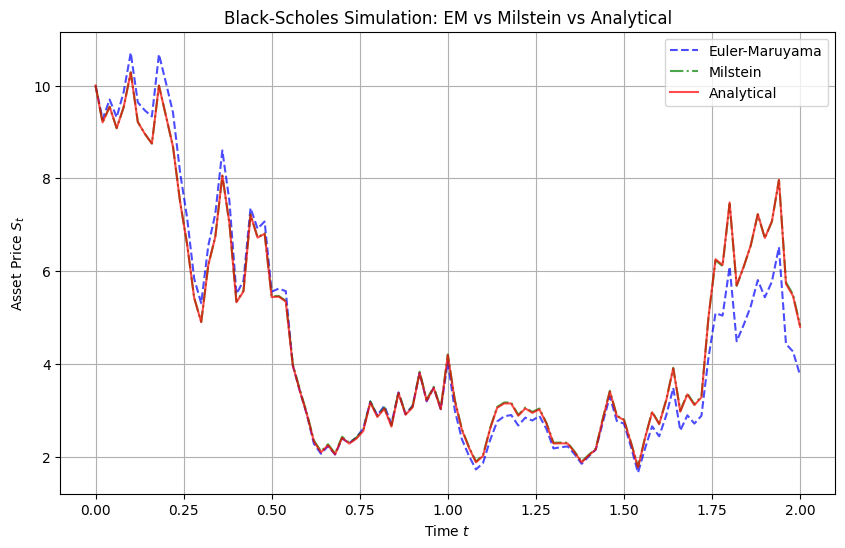

In [268]:
import numpy as np
import matplotlib.pyplot as plt


S0 = 10.0  
mu = .4   
sigma = 1  
T = 2.0       
N = 100    
dt = T / N

M = 1        

t = np.linspace(0, T, N+1)

SEuler = np.zeros((M, N+1))
SMil = np.zeros((M, N+1))
SAnalytical = np.zeros((M, N+1))

SEuler[:, 0] = S0
SMil[:, 0] = S0
SAnalytical[:, 0] = S0

dW = np.sqrt(dt) * np.random.randn(M, N)
W = np.cumsum(dW, axis=1)
W = np.hstack([np.zeros((M,1)), W]) 

for n in range(N):

    SEuler[:, n+1] = SEuler[:, n] + mu*SEuler[:, n]*dt + sigma*SEuler[:, n]*dW[:, n]
    
    SMil[:, n+1] = (SMil[:, n] 
                     + mu*SMil[:, n]*dt 
                     + sigma*SMil[:, n]*dW[:, n] 
                     + 0.5*sigma**2*SMil[:, n]*(dW[:, n]**2 - dt))
    
    SAnalytical[:, n+1] = S0 * np.exp((mu - 0.5*sigma**2)*t[n+1] + sigma*W[:, n+1])

plt.figure(figsize=(10,6))
for i in range(M):
    plt.plot(t, SEuler[i], 'b--', alpha=0.7, label='Euler-Maruyama' if i==0 else "")
    plt.plot(t, SMil[i], 'g-.', alpha=0.7, label='Milstein' if i==0 else "")
    plt.plot(t, SAnalytical[i], 'r-', alpha=0.7, label='Analytical' if i==0 else "")

plt.xlabel('Time $t$')
plt.ylabel('Asset Price $S_t$')
plt.title('Black-Scholes Simulation: EM vs Milstein vs Analytical')
plt.legend()
plt.grid(True)
plt.show()


### **Q5** : Show numerically that the second order Milstein method has strong order of convergence of 1

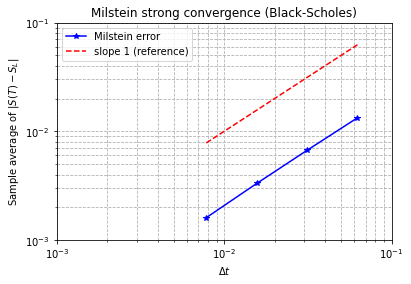

Estimated strong convergence rate q = 1.017
Residual of fit = 1.79e-02


In [47]:
import numpy as np
import matplotlib.pyplot as plt



T = 1.0        # time horizon
N = 2**11      # fine time steps
dt = T / N

# Simulation parameters
M = 500                     # number of sample paths
R = np.array([1, 16, 32, 64, 128])  # refinement factors

# Fix random seed
np.random.seed(100)

# Discretized Brownian path
dW = np.sqrt(dt) * np.random.randn(M, N)

# Preallocate Milstein results
Smil = np.zeros((M, len(R)))

# Loop over refinements
for p, Rp in enumerate(R):
    Dt = Rp * dt           # Milstein timestep
    L = N // Rp            # number of large steps
    Stemp = np.full(M, X0) # initial condition for all paths

    for j in range(L):
        # Brownian increments over each large timestep
        Winc = np.sum(dW[:, Rp*j : Rp*(j+1)], axis=1)

        Stemp = (Stemp 
                 + Dt * mu * Stemp 
                 + sigma * Stemp * Winc 
                 + 0.5 * sigma**2 * Stemp * (Winc**2 - Dt))

    Smil[:, p] = Stemp  # store Milstein solution at T

# Reference solution: smallest step (R=1)
Sref = Smil[:, 0]

# Errors for larger steps
Serr = np.abs(Smil[:, 1:] - Sref[:, None])
mean_err = np.mean(Serr, axis=0)

# Timesteps used
Dtvals = dt * R[1:]

# Plot strong error
plt.figure(figsize=(6,4))
plt.loglog(Dtvals, mean_err, 'b*-', label='Milstein error')
plt.loglog(Dtvals, Dtvals, 'r--', label='slope 1 (reference)')
plt.axis([1e-3, 1e-1, 1e-3, 1e-1])
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Sample average of $|S(T) - S_L|$')
plt.title('Milstein strong convergence (Black-Scholes)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Least squares fit: log(error) = log(C) + q log(Δt)
A = np.vstack([np.ones(len(Dtvals)), np.log(Dtvals)]).T
rhs = np.log(mean_err)
sol, _, _, _ = np.linalg.lstsq(A, rhs, rcond=None)
q = sol[1]
resid = np.linalg.norm(A @ sol - rhs)

print(f"Estimated strong convergence rate q = {q:.3f}")
print(f"Residual of fit = {resid:.2e}")


### **Q6** : Simulate the stock price for different values of volatility and estimate the probability for a 10 dollars stock price, to reach 100 dollars at t = 5

Use $\mu = .4$

# Exercise 3

# A gold particle in water

<img src="https://raw.githubusercontent.com/AlexandreThy/LINMA2720/refs/heads/main/img/gold.png" alt="goldplot" width="300">

Another situation where SDE are important, is to model the motion of a particle in a fluid. 

This physical situation can be modeled using the **Langevin Equation**, that takes the following form :

$$
mdv = -\lambda v dt + \sigma dW_t,
$$
where $v$ is the velocity of the particle, $m$ is the mass of the particle, $\lambda$ is the particle friction and $\sigma$ scales the stochastic component modeling the collision driven force.

You might recognise this equation as it is a special case of the Ornstein-Uhlenbeck process explored in the first practice session, for which $X^* = 0$

Moreover, we would like to add to our model the effect of density differences between the particle in the fluid. 

This effect involves two different forces : 

1. **Weight (downward):**  
   $F_\text{weight} = \rho_\text{particle} \, V \, g$  
   - $ \rho_\text{particle} $: density of the particle
   - $ V $: volume of the particle  
   - $ g $: gravitational acceleration  

2. **Buoyant Force (upward):**  
   $F_\text{buoyancy} = \rho_\text{water} \, V \, g$  
   - $ \rho_\text{water} $: density of water  
   
3. $\Longrightarrow$ **Net Force:**  
   $F_\text{net} = F_\text{weight} - F_\text{buoyancy}
   = (\rho_\text{particle} - \rho_\text{water}) \, V \, g$

Because $ \rho_\text{particle} > \rho_\text{water} $, the net force is **downward**, so the particle sinks.

This phenomenon is called **negative buoyancy**.

If we define a positive velocity as an upward movement, then our vertical dynamics becomes : 
$$
mdv_y = (-F_{net} - \lambda v_y) dt + \sigma_y dW_t,
$$

---

### We will here focus on a specific case of **a particle of gold sinking in water in a 2-Dimensional environment**

---

You can use the following informations : 

- **Radius:** $R = 1 \times 10^{-6} \, \text{m}$
- **Densities:**  
  $ \rho_\text{gold} = 19300 \, \text{kg/m³} $  
  $ \rho_\text{water} = 1000 \, \text{kg/m³} $

- **Viscosity of water:** $ \eta = 1 \times 10^{-3} \, \text{Pa s} $
- **Temperature:** $ T = 298.15 \, \text{K} $
- **Boltzmann constant:** $ k_B = 1.380649 \times 10^{-23} \, \text{J/K} $

### Volume of the spheric Particle

$ V = \frac{4}{3} \pi R^{3} $

### Mass of the Particle

$ m = \frac{4}{3} \pi R^{3} \rho_\text{gold} $

### Stokes Friction Coefficient

$ \lambda = 6 \pi \eta R $

### Variance of the gaussian distribution of collisions

$ \sigma^2 = 2 \lambda k_B T $


More information available at https://www2.ph.ed.ac.uk/~dmarendu/ASP/Section14.pdf

### **Q7** : Simulate few possible trajectories of the motion of the gold particle over 100 ms using the Euler-Maruyama method

Hint : Use a sufficiently small timestep of $10^{-6}$ s



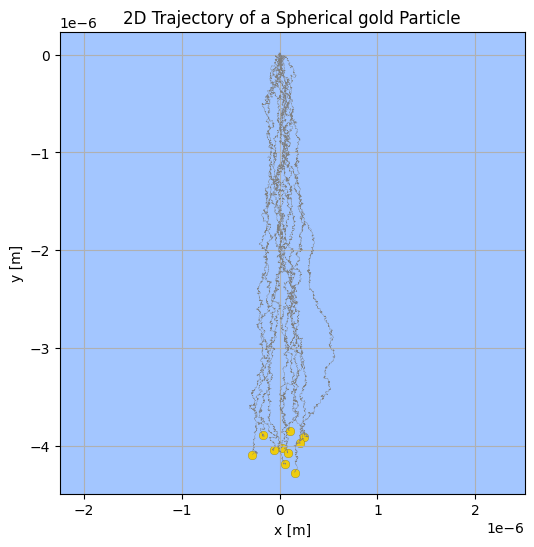

In [1]:
import numpy as np
import matplotlib.pyplot as plt

R = 1e-6          
rho_gold = 19300
rho_water = 1000        
eta = 1e-3          
T = 298.15         
kB = 1.380649e-23   
V = (4/3)*np.pi*R**3
g = 9.81
Fg = (rho_gold - rho_water) * V * g   

m = (4/3) * np.pi * R**3 * rho_gold  
gamma = 6 * np.pi * eta * R       

sigma_v = np.sqrt(2 * gamma * kB * T) / m

dt = 1e-6  
n_steps = int(1e5) 
time = np.arange(0, n_steps*dt, dt)
    
plt.figure(figsize=(6,6)) 
ax = plt.gca()  
ax.set_facecolor("#a3c6ff") 
sample_step = max(1, n_steps // 5000)

def let_it_sink(gamma,sigma_v,Fg,m,dt,num_sim = 10):


    vx = np.zeros((num_sim,n_steps))
    vy = np.zeros((num_sim,n_steps))
    x = np.zeros((num_sim,n_steps))
    y = np.zeros((num_sim,n_steps))


    for n in range(num_sim):




        x[n,0] = 0
        y[n,0] = 0
        vx[n,0] = 0
        vy[n,0] = 0

        rand_vx = np.random.randn(n_steps-1)
        rand_vy = np.random.randn(n_steps-1)

        for i in range(n_steps-1):

            vx[n,i+1] = vx[n,i] + (-gamma/m * vx[n,i]) * dt + sigma_v * np.sqrt(dt) * rand_vx[i] 
            vy[n,i+1] = vy[n,i] + (-gamma/m * vy[n,i]) * dt + sigma_v * np.sqrt(dt) * rand_vy[i] - Fg/m * dt
            x[n,i+1] = x[n,i] + vx[n,i+1] * dt
            y[n,i+1] = y[n,i] + vy[n,i+1] * dt


    return x,y

num_sim = 10
x,y = let_it_sink(gamma,sigma_v,Fg,m,dt,num_sim)
for n in range(num_sim):
    plt.plot(x[n,::sample_step], y[n,::sample_step], color="grey",linewidth = .2)
    plt.scatter(x[n,-1], y[n,-1],s=40, color="#EECC0E", edgecolors="black", label="Gold particle", linewidths=.1)


plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('2D Trajectory of a Spherical gold Particle')
plt.axis('equal')
plt.grid(True)
plt.show()

### **Q8** : Calculate the expression of the Second Order Milstein method, is it different from the Euler-Maruyama ? Explain

**Answer** : The expression is the same as the second order terms are zero since the stochastic part of the SDE is a Brownian x constant

### **Q9** : Simulate the model with 1000 gold particles uniformly distributed at the same height and Illustrate. 

You can ignore the collision between gold particles

**Answer** : **Plot To Do**

### **Q10** : Simulate the model with multiple other particle elements than gold and compare them. 

**Answer** : They just have to change the density of the particle. The denser the particle, the more the "drowning effect" will be compared to the magnitude of the stochastic part

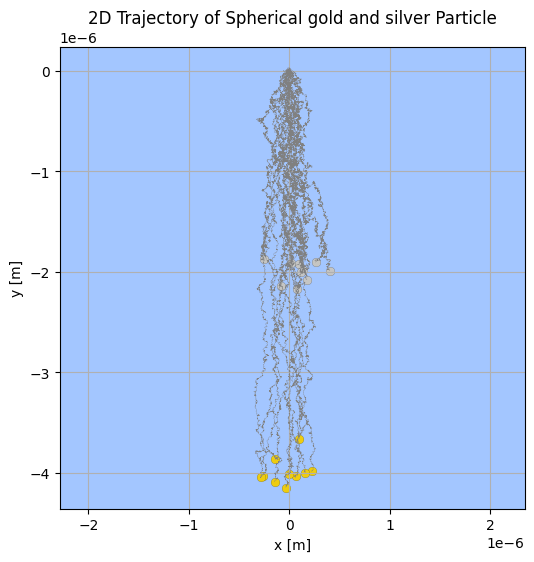

In [2]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6)) 
ax = plt.gca()  
ax.set_facecolor("#a3c6ff") 
x,y = let_it_sink(gamma,sigma_v,Fg,m,dt,num_sim)
for n in range(num_sim):
    plt.plot(x[n,::sample_step], y[n,::sample_step], color="grey",linewidth = .2)
    plt.scatter(x[n,-1], y[n,-1],s=40, color="#EECC0E", edgecolors="black", label="Gold particle", linewidths=.1)
rho_silver = 10490 ## J'ai changé ici la densité de l'or par celle de l'argent 
Fg = (rho_silver - rho_water) * V * g   

m = (4/3) * np.pi * R**3 * rho_silver 
gamma = 6 * np.pi * eta * R       

sigma_v = np.sqrt(2 * gamma * kB * T) / m
num_sim = 10
x,y = let_it_sink(gamma,sigma_v,Fg,m,dt,num_sim)
for n in range(num_sim):
    plt.plot(x[n,::sample_step], y[n,::sample_step], color="grey",linewidth = .2)
    plt.scatter(x[n,-1], y[n,-1],s=40, color="#C5C5C3", edgecolors="black", label="Silver particle", linewidths=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('2D Trajectory of Spherical gold and silver Particle')
plt.axis('equal')
plt.grid(True)
plt.show()

# Exercise 4 

# Fox and rabbits

<img src="https://raw.githubusercontent.com/AlexandreThy/LINMA2720/refs/heads/main/img/FoxRabbits.png" alt="goldplot" width="600">

## Prey-Predator System

**Stochastic differential equations** are also valuable to model real ecological and biological systems as birth, death, and interaction events occur at random times, and environmental fluctuations can cause population sizes to deviate significantly from their mean-field trajectories.

We will focus in this exercise on the modelization of a predator-prey system where foxes eat rabbits to survive. 
This competitive population dynamics can be model using a stochastic **Lotka-Volterra model** 

## Dynamics

$$
dX_t = (\alpha X_t - \beta X_tY_t) \, dt + \sigma_x X_t \, dW_t
$$

$$
dY_t = (\delta X_tY_t - \gamma Y_t) \, dt + \sigma_y Y_t \, dW_t
$$

Where:

- $X_t$: Population of the prey at time \(t\)  
- $Y_t$: Population of the predator at time \(t\)  

## Parameters:

- $\alpha = 10$: Prey growth rate  
- $\beta = .7$ Predation rate  
- $\gamma = .5$: Predator death rate  
- $\delta =.5 $: Predator reproduction rate  

- $\sigma_x = 4$: Noise intensity affecting prey population  
- $\sigma_y = 4$: Noise intensity affecting predator population  

You can start with an initial population of 50 rabbits, and two foxes

## Timesteps:

The smaller the timestep, the less differences you will observe between the first order Euler-Maruyama Method and the second order Milstein method.
Start by using a timestep dt = $2\times 10^{-3}$ for an Horizon of T = 2


### **Q11** : Implement a possible evolutions of the two populations using a $2^{\text{nd}}$ order Milstein method and compare it with the Euler-Maruyama method

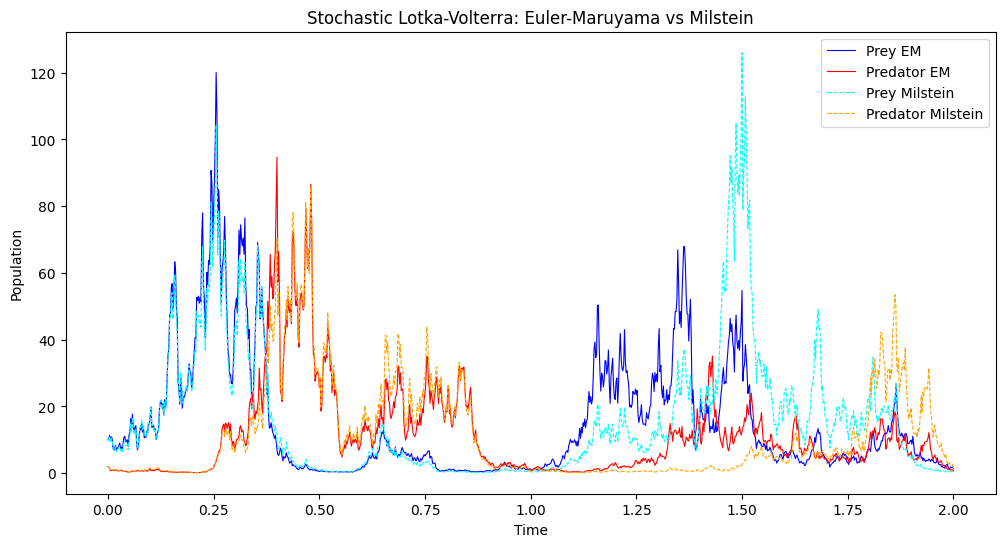

In [4]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 10
beta = .7
gamma = .5
delta = .5
sigma1 = 4
sigma2 = 4


x0 = 10
y0 = 2
T = 2
N = 1000
dt = T/N
t = np.linspace(0, T, N+1)
dW1 = np.sqrt(dt) * np.random.randn(N)
dW2 = np.sqrt(dt) * np.random.randn(N)

def euler_maruyama_lv(x0, y0, alpha, beta, gamma, delta, sigma1, sigma2, dt, N, dW1, dW2):
    X = np.zeros(N+1)
    Y = np.zeros(N+1)
    X[0] = x0
    Y[0] = y0
    for i in range(N):
        X[i+1] = X[i] + (alpha*X[i] - beta*X[i]*Y[i])*dt + sigma1*X[i]*dW1[i]
        Y[i+1] = Y[i] + (delta*X[i]*Y[i] - gamma*Y[i])*dt + sigma2*Y[i]*dW2[i]
    return X, Y

def milstein_second_order_lv(x0, y0, alpha, beta, gamma, delta, sigma1, sigma2, dt, N, dW1, dW2):
    X = np.zeros(N+1)
    Y = np.zeros(N+1)
    X[0] = x0
    Y[0] = y0
    for i in range(N):
        
        X[i+1] = X[i] + (alpha*X[i] - beta*X[i]*Y[i])*dt + sigma1*X[i]*dW1[i] + 0.5*sigma1**2*X[i]*(dW1[i]**2 - dt)
        Y[i+1] = Y[i] + (delta*X[i]*Y[i] - gamma*Y[i])*dt + sigma2*Y[i]*dW2[i]+ 0.5*sigma2**2*Y[i]*(dW2[i]**2 - dt)
    return X, Y


np.random.seed(4)
X_em, Y_em = euler_maruyama_lv(x0, y0, alpha, beta, gamma, delta, sigma1, sigma2, dt, N, dW1, dW2)
X_mil, Y_mil = milstein_second_order_lv(x0, y0, alpha, beta, gamma, delta, sigma1, sigma2, dt, N, dW1, dW2)

plt.figure(figsize=(12,6))
plt.plot(t, X_em, label="Prey EM", color="blue",linewidth = .8)
plt.plot(t, Y_em, label="Predator EM", color="red",linewidth = .8)
plt.plot(t, X_mil, '--', label="Prey Milstein", color="cyan",linewidth = .8)
plt.plot(t, Y_mil, '--', label="Predator Milstein", color="orange",linewidth = .8)
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Stochastic Lotka-Volterra: Euler-Maruyama vs Milstein")
plt.legend()
plt.show()


### **Q12** : For each parameter, test and explain how its value impacts the differences between the Euler-Maruyama Method and the $2^{\text{nd}}$ order Milstein Method ?

# Exercise 5 

### **Q13** : Reproduce your application done at the end of the last practice session with the $2^{\text{nd}}$ order Milstein Method instead of Euler-Maruyama, observe and comment the differences.